# Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations
from collections import Counter
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

In [9]:
class SVC():
    def __init__(self, kernel=None, gamma = None, coef0=0):
        self.labels_map = None
        self.kernel = kernel
        self.X = None
        self.y = None
        self.alphas = None
        self.w = None
        self.b = None
        self.gamma = gamma
        self.coef0 = coef0
        if kernel is not None:
            assert kernel in ['poly', 'rbf', 'sigmoid']
        
    def fit(self, X, y):
        uniq_labels = np.unique(y)
        assert len(uniq_labels) == 2
        
            
        self.make_label_map(uniq_labels)
        self.X = X
        
        if not self.gamma:
            gamma = 1/(X.shape[1]*X.var())
        
        y = [self.transform_label(label, self.labels_map) for label in y] ## 1, -1로 변환
        y = np.array(y)
        ## formulating standard form
        m, n = X.shape
        y = y.reshape(-1,1)*1.
        self.y = y
        if self.kernel is not None:
            K = np.zeros((m,m))
            for i in range(m):
                for j in range(m):
                    K[i][j] = y[i]*y[j]*self.get_kernel_val(X[i], X[j])                       
        else:
            yX = y*X
            K = np.dot(yX,yX.T)
        P = cvxopt_matrix(K)
        q = cvxopt_matrix(-np.ones((m, 1)))
        G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
        A = cvxopt_matrix(y.reshape(1, -1))
        b = cvxopt_matrix(np.zeros(1))
        ## cvxopt configuration
        cvxopt_solvers.options['show_progress'] = False ## 결과 출력 X
        sol = cvxopt_solvers.qp(P, q, G, h, A, b) 
        alphas = np.array(sol['x'])
        S = (alphas>1e-4).flatten()
        
        if not self.gamma:
            gamma = 1/(X.shape[1]*X.var())
        
        if self.kernel is not None:
            sum_val = 0
            S_index = np.where(S==True)[0]
            for s in S_index:
                temp_vec = np.array([self.get_kernel_val(z, X[s]) for z in X])
                temp_vec = np.expand_dims(temp_vec, axis=1)
                sum_val += np.sum(y[s] - np.sum(y*alphas*temp_vec))
            b = sum_val/len(S)
            self.b = b
        else:
            w = ((y*alphas).T@X).reshape(-1,1)
            b = np.mean(y[S] - np.dot(X[S],w))
            self.w = w
            self.b = b
        self.alphas = alphas
        
        return
    
    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        
        return predictions
    
    def _predict(self, x):
        if self.kernel:
            temp_vec = np.array([self.get_kernel_val(x, y) for y in self.X])
            temp_vec = np.expand_dims(temp_vec, axis=1)
            S = (self.alphas>1e-4).flatten()
            res = np.sign(np.sum(self.y[S]*self.alphas[S]*temp_vec[S])+self.b)
        else:
            res = np.sign(self.w.T.dot(x)+self.b)
        res = self.inverse_label(res, self.labels_map)
        
        return res
    
    def make_label_map(self, uniq_labels):
        labels_map = list(zip([-1, 1], uniq_labels))
        self.labels_map = labels_map
        
        return
    
    def transform_label(self, label, labels_map):
        res = [l[0] for l in labels_map if l[1] == label][0]
        
        return res

    def inverse_label(self, svm_label, labels_map):
        try:
            res = [l[1] for l in labels_map if l[0] == svm_label][0]
        except:
            print(svm_label)
            print(labels_map)
            raise
        
        return res
    
    def get_kernel_val(self, x, y):
        X = self.X
        coef0 = self.coef0
        if not self.gamma:
            gamma = 1/(X.shape[1]*X.var())
            
        if self.kernel == 'poly':
            return (gamma*np.dot(x,y)+coef0)**2
        elif self.kernel == 'rbf':
            return np.exp(-gamma*np.square(np.linalg.norm(x-y)))
        else:
            return np.tanh(gamma*np.dot(x,y)+coef0)

In [27]:
class SVM():
    def __init__(self, type='classification', kernel=None, gamma=None, C=None, coef0=0):
        assert type in ['classification', 'regression']
        self.type = type
        self.kernel=kernel
        self.X = None
        self.y = None
        self.coef0 = coef0
        self.model_list = None
        self.gamma = gamma
        self.C = C
        if kernel is not None:
            assert kernel in ['poly', 'rbf', 'sigmoid']
            
    def fit(self, X, y, epsilon=[0.1, 0.01, 0.001]):
        if self.type == 'classification':
            self._fit_svc(X, y)
        else:
            self._fit_svr(X, y, epsilon)
            
    def _fit_svc(self, X, y):
        uniq_labels = np.unique(y)
        label_combinations = list(combinations(uniq_labels, 2))
        model_list = []
        for lc in label_combinations:
            target_idx = np.array([x in lc for x in y])
            y_restricted = y[target_idx]
            X_restricted = X[target_idx]
            clf = SVC(kernel=self.kernel, coef0=self.coef0)
            clf.fit(X_restricted, y_restricted)
            model_list.append(clf)
        
        self.model_list = model_list
        return
    
    def _fit_svr(self, X, y, epsilon):

        assert epsilon > 0
        self.X = X
        m, n = X.shape
        y = y.reshape(-1,1)*1.
        self.y = y
        if self.kernel is not None:
            K = np.zeros((m,m))
            for i in range(m):
                for j in range(m):
                    K[i][j] = self.get_kernel_val(X[i], X[j])
        else:
            K = X.dot(X.T)
        I = np.eye(m)
        O = np.zeros((m, m))
        sub_K = np.hstack([I, -I])
        main_K = sub_K.T.dot(K.dot(sub_K))
        P = cvxopt_matrix(main_K)
        q = cvxopt_matrix(epsilon*np.ones((2*m, 1)) - np.vstack([y, -y]))

        G = np.vstack([np.hstack([-I, O]), np.hstack([I, O]), np.hstack([O, -I]), np.hstack([O, I])])
        G = cvxopt_matrix(G)
        h = cvxopt_matrix(np.hstack([np.zeros(m), C*np.ones(m)]*2))
        A = cvxopt_matrix(np.ones((m,1)).T.dot(sub_K))
        b = cvxopt_matrix(np.zeros(1))
        
        cvxopt_solvers.options['show_progress'] = False
        sol = cvxopt_solvers.qp(P, q, G, h, A, b)
        sol_root = np.array(sol['x'])
        alphas = sol_root[:m]
        alphas_star = sol_root[m:]
        
        S = (alphas>1e-4).flatten()       
        if self.kernel is not None:
            sum_val = []
            S_index = np.where(S==True)[0]
            for s in S_index:
                temp_vec = np.array([self.get_kernel_val(z, X[s]) for z in X])
                temp_vec = np.expand_dims(temp_vec, axis=1)
                sum_val.append(-epsilon + np.sum(y[s] - np.sum((alphas-alphas_star)*temp_vec)))
            b = min(sum_val)
            self.b = b

        else:
            w = alphas.T.dot(X)-alphas_star.T.dot(X)
            w = w.reshape(-1,1)
            b = -epsilon+np.min(y[S] - np.dot(X[S],w))
            self.w = w
            self.b = b
        self.alphas = sol_root
        
        return
    
    def predict(self, X):
        if self.type =='classification':
            model_list = self.model_list
            prediction = [model.predict(X) for model in model_list]
            prediction = [Counter(pred).most_common(1)[0][0] for pred in list(zip(*prediction))]
        else:
            prediction = [self._predict_reg(x) for x in X]
        return prediction
    
    def _predict_reg(self, x):
        X = self.X
        
        if self.kernel is not None:
            m, _ = self.X.shape
            sol_root = self.alphas
            alphas = sol_root[:m]
            alphas_star = sol_root[m:]
            
            temp_vec = np.array([self.get_kernel_val(z, x) for z in X])
            temp_vec = np.expand_dims(temp_vec, axis=1)
            pred = np.sum((alphas-alphas_star)*temp_vec)+self.b
        else:
            w = self.w
            b = self.b
            pred = w.dot(x)+b
            pred = pred[0]
        return pred
    
    def get_kernel_val(self, x, y):
        X = self.X
        coef0 = self.coef0
        
        if not self.gamma:
            gamma = 1/(X.shape[1]*X.var())
            
        if self.kernel == 'rbf':
            return np.exp(-gamma*np.square(np.linalg.norm(x-y)))
        elif self.kernel == 'poly':
            return (gamma*np.dot(x,y)+coef0)**2 
        elif self.kernel == 'sigmoid':
            return np.tanh(gamma*np.dot(x,y)+coef0)

In [24]:
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = [iris.target_names[x] for x in iris.target]
 
species_to_labels = dict(zip(df['species'].unique(), range(len(df['species'].unique()))))
df['species'] = df['species'].map(species_to_labels)
df = df.rename(columns={'species':'label'})

X = df.drop('label', axis=1).values
y = df['label'].values

In [25]:
clf = SVM(type='classification')


In [13]:
for kernel in ['poly', 'rbf', 'sigmoid']:
    for gamma in [0.001, 0.01, 0.1, 1]:
        for C in [0.1, 1, 10, 100, 1000]:
            clf = SVM(type='classification',kernel = kernel, gamma= gamma, C=C)
            clf.fit(X, y)
            pred = clf.predict(X)
            print('kernel:', kernel, 'C:', C, 'gamma:', gamma, 'Accuracy:', np.mean(y==pred))

kernel: poly C: 0.1 gamma: 0.001 Accuracy: 0.48
kernel: poly C: 1 gamma: 0.001 Accuracy: 0.6266666666666667
kernel: poly C: 10 gamma: 0.001 Accuracy: 0.6266666666666667
kernel: poly C: 100 gamma: 0.001 Accuracy: 0.6266666666666667
kernel: poly C: 1000 gamma: 0.001 Accuracy: 0.6533333333333333
kernel: poly C: 0.1 gamma: 0.01 Accuracy: 0.48
kernel: poly C: 1 gamma: 0.01 Accuracy: 0.6266666666666667
kernel: poly C: 10 gamma: 0.01 Accuracy: 0.6266666666666667
kernel: poly C: 100 gamma: 0.01 Accuracy: 0.6266666666666667
kernel: poly C: 1000 gamma: 0.01 Accuracy: 0.6533333333333333
kernel: poly C: 0.1 gamma: 0.1 Accuracy: 0.48
kernel: poly C: 1 gamma: 0.1 Accuracy: 0.6266666666666667
kernel: poly C: 10 gamma: 0.1 Accuracy: 0.6266666666666667
kernel: poly C: 100 gamma: 0.1 Accuracy: 0.6266666666666667
kernel: poly C: 1000 gamma: 0.1 Accuracy: 0.6533333333333333
kernel: poly C: 0.1 gamma: 1 Accuracy: 0.48
kernel: poly C: 1 gamma: 1 Accuracy: 0.6266666666666667
kernel: poly C: 10 gamma: 1 Accur

## Regression

In [29]:
from sklearn.datasets import load_boston
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['y'] = boston.target

In [30]:
X = df[['LSTAT']].values
y = df['y'].values

In [31]:
reg = SVM(type='regression')
reg.fit(X, y, epsilon= 1)
np.mean(np.square(y-reg.predict(X)))

46.613252006538524

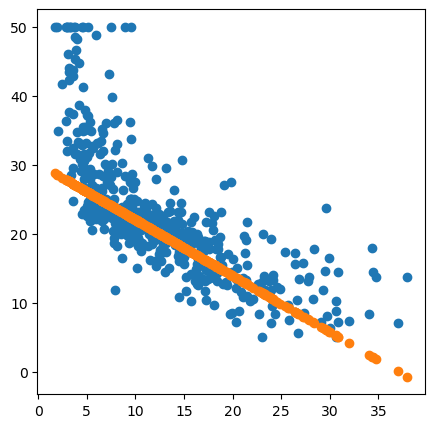

In [32]:
fig = plt.figure(figsize=(5,5))
fig.set_facecolor('white')
plt.scatter(X.flatten(), y)
plt.scatter(X.flatten(), reg.predict(X))
plt.show()

In [36]:
for kernel in ['poly', 'rbf']:
    reg1 = SVM(type='regression', kernel=kernel)
    reg1.fit(X, y, epsilon= 1)
    pred = reg1.predict(X)
    mse = np.mean(np.square(y-pred))
    print('Kernel:', kernel, 'epsilon: 1', 'MSE:', mse)
        
for kernel in ['poly', 'rbf']:
    reg2 = SVM(type='regression', kernel=kernel)
    reg2.fit(X, y, epsilon= 0.1)
    pred = reg2.predict(X)
    mse = np.mean(np.square(y-pred))
    print('Kernel:', kernel, 'epsilon: 0.1', 'MSE:', mse)

for kernel in ['poly', 'rbf']:
    reg3 = SVM(type='regression', kernel=kernel)
    reg3.fit(X, y, epsilon= 0.01)
    pred = reg3.predict(X)
    mse = np.mean(np.square(y-pred))
    print('Kernel:', kernel, 'epsilon: 0.01', 'MSE:', mse)
    
for kernel in ['poly', 'rbf']:
    reg4 = SVM(type='regression', kernel=kernel)
    reg4.fit(X, y, epsilon= 0.001)
    pred = reg4.predict(X)
    mse = np.mean(np.square(y-pred))
    print('Kernel:', kernel, 'epsilon: 0.001', 'MSE:', mse)

for kernel in ['poly', 'rbf']:
    reg5 = SVM(type='regression', kernel=kernel)
    reg5.fit(X, y, epsilon= 0.0001)
    pred = reg5.predict(X)
    mse = np.mean(np.square(y-pred))
    print('Kernel:', kernel, 'epsilon: 0.0001', 'MSE:', mse)


    
    # fig = plt.figure(figsize=(8,8))
    # fig.set_facecolor('white')
    # plt.scatter(X.flatten(), y)
    # plt.scatter(X.flatten(), pred)
    # plt.title(kernel)
    # plt.show()

Kernel: poly epsilon: 1 MSE: 58.51204426380987
Kernel: rbf epsilon: 1 MSE: 30.25441538874462
Kernel: poly epsilon: 0.1 MSE: 57.30174733415406
Kernel: rbf epsilon: 0.1 MSE: 86.89142735661936
Kernel: poly epsilon: 0.01 MSE: 92.53784605321853
Kernel: rbf epsilon: 0.01 MSE: 27.9975753096193
Kernel: poly epsilon: 0.001 MSE: 56.86410803324638
Kernel: rbf epsilon: 0.001 MSE: 32.31841639922789
Kernel: poly epsilon: 0.0001 MSE: 56.860306852005216
Kernel: rbf epsilon: 0.0001 MSE: 67.55925526060597
